# NAIVE BAYES CLASSIFIER

In [1]:
import mido # https://github.com/mido/mido
import midi # https://github.com/vishnubob/python-midi
import random
import numpy as np
import scipy as sp
from collections import defaultdict, Counter
import itertools
import statistics as stats

## Functions

In [2]:
def midi_to_unigram(FILE_NAME, BASE_TICK, LOWEST_NOTE):
    """Returns an array of current states (notes) given a midi file, base_tick, and the lowest note
    """
    # Initializations
    current_state = 0;

    # Open the MIDI file
    pattern = midi.read_midifile( FILE_NAME );
    
    # Initialize list to store unigrams
    current_states = []

    # Read the file for note on and off events
    for line in pattern:
        for event in line:
            if type(event) == midi.events.NoteOffEvent or type(event) == midi.events.NoteOnEvent:

                # Write the state enough number of times
                for x in range(0, int( round( float(event.tick) / float(BASE_TICK) ) ) ):
                    current_states.append(current_state)
                
                if type(event) == midi.events.NoteOffEvent or event.get_velocity() <= 0:
                    if event.get_pitch() == current_state + LOWEST_NOTE - 1:
                        current_state = 0;
                else:
                    current_state = event.get_pitch() - LOWEST_NOTE + 1;
    
    return current_states

In [3]:
def remove_zeros(states, k):
    """Removes long pauses in the piece (only allows for 0 to appear k times consecutively)
    """
    new_states = []
    count = 0 # counts the number of consecutive 0's
    
    for s in states:
        if s == 0: # if current state is a 0
            count += 1
            if count <= k:
                new_states.append(s)
        else:
            count = 0 # reset counter
            new_states.append(s)
                
    return new_states

In [4]:
def all_ngrams(vocabulary, n):
    """Returns a list of all `n`-long *tuples* of elements of the `vocabulary`.
    
    For instance,  
        >>> all_ngrams(["one", "two"], 3)
        [('one', 'one', 'one'),
         ('one', 'one', 'two'),
         ('one', 'two', 'one'),
         ('one', 'two', 'two'),
         ('two', 'one', 'one'),
         ('two', 'one', 'two'),
         ('two', 'two', 'one'),
         ('two', 'two', 'two')]
         
    Order of returned list is not specified or guaranteed.
    When `n`=0, return [()].
    """
    return list(itertools.product(vocabulary, repeat=n))

In [5]:
def ngrams(notes_list, n):
    """Returns a list of all `n`-grams in a list of `notes`."""
    return [tuple(notes_list[i : i + n])
            for i in range(0, len(notes_list) - n + 1)]

In [6]:
def ngram_counts(vocabulary, notes_list, n):
    """Returns a dictionary of counts of the `n`-grams in `notes_list`.
    
    The dictionary is structured with first index by (n-1)-gram context
    and second index by the final target note.
    """
    context_dict = defaultdict(lambda: defaultdict(int))
    # zero all ngrams
    for context in all_ngrams(vocabulary, n - 1):
        for target in vocabulary:
            context_dict[context][target] = 0
    # add counts for attested ngrams
    for ngram, count in Counter(ngrams(notes_list, n)).items():
        context_dict[ngram[:-1]][ngram[-1]] = count
    return context_dict

In [7]:
def ngram_model(ngram_counts):
    """Returns an n-gram probability model calculated by normalizing the 
       provided `ngram-counts` dictionary
    """
    ngram_probs = defaultdict(lambda: defaultdict(float))
    for history in list(ngram_counts.keys()):
        for next_note in list(ngram_counts[history].keys()):
            try:
                ngram_probs[history][next_note] = (ngram_counts[history][next_note])/(sum(ngram_counts[history].values()))
            except:
                ngram_probs[history][next_note] = 0.0
    return ngram_probs

In [8]:
def get_gram_counts(MIDI_FILE, n):
    """
    Function takes in a midi file and returns the counts for the states
    """
    # get necessary information, like lowest note, base tick, bpm
    pattern = midi.read_midifile( MIDI_FILE );
    
    notes_list = []
    ticks_list = [] 
    bpm_list = []
    for line in pattern:
        for event in line:
            # get instrument
            if type(event) == midi.events.ProgramChangeEvent:
                INSTRUMENT = event.get_value()
            
            # get BPM
            if type(event) == midi.events.SetTempoEvent:
                bpm_list.append(int(event.get_bpm()))

            if type(event) == midi.events.NoteOffEvent or type(event) == midi.events.NoteOnEvent:
                notes_list.append(event.get_pitch())
                ticks_list.append(event.tick)
    
    if not bpm_list:
        BPM = 100
    else:
        BPM = stats.mode(bpm_list)
    
    notes = list(set(notes_list))
    notes.sort()
    ticks = list(set(ticks_list))
    ticks.sort()
    
    # get number corresponding to lowest note in the piece
#     LOWEST_NOTE = 0
    LOWEST_NOTE = notes[0]
    
    # get lowest tick interval (interval all ticks can be evenly divided by)
    if len(ticks) > 1:
        BASE_TICK = ticks[1]
    else:
        BASE_TICK = ticks[0]
    
    # midi to unigram
#     current_states = midi_to_unigram(MIDI_FILE, BASE_TICK, LOWEST_NOTE)
    current_states = remove_zeros(midi_to_unigram(MIDI_FILE, BASE_TICK, LOWEST_NOTE), 2)

    vocabulary = list(set(current_states))
    gram_counts = ngram_counts(vocabulary, current_states, n)
    
    return gram_counts

In [9]:
def get_gram_counts_transpose(MIDI_FILE, n):
    """
    Function takes in a midi file and returns the counts for the states
    """
    # get necessary information, like lowest note, base tick, bpm
    pattern = midi.read_midifile( MIDI_FILE );
    
    notes_list = []
    ticks_list = [] 
    bpm_list = []
    for line in pattern:
        for event in line:
            # get instrument
            if type(event) == midi.events.ProgramChangeEvent:
                INSTRUMENT = event.get_value()
            
            # get BPM
            if type(event) == midi.events.SetTempoEvent:
                bpm_list.append(int(event.get_bpm()))

            if type(event) == midi.events.NoteOffEvent or type(event) == midi.events.NoteOnEvent:
                notes_list.append(event.get_pitch() + 3)
                ticks_list.append(event.tick)

    if not bpm_list:
        BPM = 100
    else:
        BPM = stats.mode(bpm_list)
    
    notes = list(set(notes_list))
    notes.sort()
    ticks = list(set(ticks_list))
    ticks.sort()
    
    # get number corresponding to lowest note in the piece
#     LOWEST_NOTE = 0
    LOWEST_NOTE = notes[0]
    
    # get lowest tick interval (interval all ticks can be evenly divided by)
    if len(ticks) > 1:
        BASE_TICK = ticks[1]
    else:
        BASE_TICK = ticks[0]
    
    # midi to unigram
#     current_states = midi_to_unigram(MIDI_FILE, BASE_TICK, LOWEST_NOTE)
    current_states = remove_zeros(midi_to_unigram(MIDI_FILE, BASE_TICK, LOWEST_NOTE), 2)
    
    
    vocabulary = list(set(current_states))
    gram_counts = ngram_counts(vocabulary, current_states, n)
    
    return gram_counts

# NAIVE BAYES MODEL

![title](likelihood.png)

$L(w)$ is the likelihood of n-gram $w$ appearing in the corpus/training set $D_t$ (baroque_counts, romantic_counts)

$n_w(D_t)$ is the number of times n-gram $w$ appears in the training set.

$n_o(D_t)$ is the number of n-grams in the training set.

In [10]:
def calculate_likelihood(gram_counts, baroque_counts, romantic_counts):
    """
    Input: Pass the gram counts (test data) and the corresponding baroque and romantic counts (train data).
           When an unknown note transition appears, skip over it.
    Output: Prediction of baroque or romantic
    """

    # Log probability: smaller the magnitude, the more likely it is
    log_p_b = 0 # log probability that it is baroque
    log_p_r = 0 # log probability that it is romantic
    
    # Get the number of total counts
    N_b = 0 # baroque training
    for key in baroque_counts:
        N_b += sum(baroque_counts[key].values())
    N_r = 0 # romantic training
    for key in romantic_counts:
        N_r += sum(romantic_counts[key].values())

    for key in gram_counts:
        for state in gram_counts[key]:
            if baroque_counts[key][state] != 0:
                likelihood = baroque_counts[key][state]/ N_b
                log_p_b += gram_counts[key][state] * np.log(likelihood)
        for state in gram_counts[key]:
            if romantic_counts[key][state] != 0:
                likelihood = romantic_counts[key][state]/ N_r
                log_p_r += gram_counts[key][state] * np.log(likelihood)

#     print('log_p_b', log_p_b)
#     print('log_p_r', log_p_r)
    if abs(log_p_b) < abs(log_p_r):
        print('Prediction: Piece is Baroque')
        return 'B'
    else:
        print('Prediction: Piece is Romantic')
        return 'R'


![title](likelihood_smoothed.png)

$\alpha$ is the smoothing constant.

$|V|$ is the vocabulary size in the corpus.

In [11]:
# Laplace smoothing
def calculate_smoothed_likelihood(alpha, gram_counts, baroque_counts, romantic_counts):
    """
    Input: Pass the gram counts (test data) and the corresponding baroque and romantic counts (train data).
           Laplace smoothing has been implemented as a solution to dealing with unknown n-grams
    Output: Prediction of baroque or romantic
    """

    # Log probability: smaller the magnitude, the more likely it is
    log_p_b = 0 # log probability that it is baroque
    log_p_r = 0 # log probability that it is romantic
    
    # Get the number of total counts
    N_b = 0 # baroque training
    for key in baroque_counts:
        N_b += sum(baroque_counts[key].values())
    N_r = 0 # romantic training
    for key in romantic_counts:
        N_r += sum(romantic_counts[key].values())
        
    # Vocabulary size
    V_b = len(baroque_counts.keys())
    V_r = len(romantic_counts.keys())
    

    for key in gram_counts:
        for state in gram_counts[key]:
            likelihood = (baroque_counts[key][state] + alpha) / (N_b + alpha * V_b)
            log_p_b += gram_counts[key][state] * np.log(likelihood)
        for state in gram_counts[key]:
            likelihood = (romantic_counts[key][state] + alpha) / (N_r + alpha * V_r)
            log_p_r += gram_counts[key][state] * np.log(likelihood)

#     print('log_p_b', log_p_b)
#     print('log_p_r', log_p_r)
    if abs(log_p_b) < abs(log_p_r):
        print('Prediction: Piece is Baroque')
        return 'B'
    else:
        print('Prediction: Piece is Romantic')
        return 'R'

# LIKELIHOODS BASED ON TRAIN DATA

## ATTEMPT 1: aggregate all note transitions for the training baroque pieces and romantic pieces

In [12]:
import os
from os import listdir
from os.path import isfile, join

mypath_b = 'MIDI PERIOD CLASSIFICATION/Baroque/'
b_files = [mypath_b+f for f in listdir(mypath_b) if (isfile(join(mypath_b, f))) and (f != '.DS_Store') and ('split' not in f)]

mypath_r = 'MIDI PERIOD CLASSIFICATION/Romantic/'
r_files = [mypath_r+f for f in listdir(mypath_r) if (isfile(join(mypath_r, f))) and (f != '.DS_Store') and ('split' not in f)]

b_files.sort()
r_files.sort()

In [13]:
from sklearn.model_selection import train_test_split

b_train, b_test = train_test_split(b_files, test_size=0.4, shuffle = True, random_state = 114)

r_train, r_test = train_test_split(r_files, test_size=0.4, shuffle = True, random_state = 114)

In [14]:
# baseline model calculations
len(b_test) + len(r_test)

28

In [15]:
print(f'Probability that baseline model gets baroque right: {len(b_test)/28 * 100:.2f}%')

Probability that baseline model gets baroque right: 53.57%


In [16]:
# train Baroque

train_list_b = []

for b_file in b_train:
    train_list_b.append(get_gram_counts(b_file,2))

In [17]:
# train Romantic

train_list_r = []

for r_file in r_train:
    train_list_r.append(get_gram_counts(r_file,2))

In [18]:
for train_piece in train_list_b[1:]:
    for key, value in train_piece.items():
        for subkey, subvalue in value.items():
            train_list_b[0][key][subkey] = subvalue + train_list_b[0][key][subkey]

In [19]:
for train_piece in train_list_r[1:]:
    for key, value in train_piece.items():
        for subkey, subvalue in value.items():
            train_list_r[0][key][subkey] = subvalue + train_list_r[0][key][subkey]

In [20]:
# NUMBER OF NOTE TRANSITIONS FOR BAROQUE
total = 0
for k1 in train_list_b[0]:
    for k2 in train_list_b[0][k1]:
        total += train_list_b[0][k1][k2]
    
total

545239

In [21]:
# NUMBER OF NOTE TRANSITIONS FOR ROMANTIC
total = 0
for k1 in train_list_r[0]:
    for k2 in train_list_r[0][k1]:
        total += train_list_r[0][k1][k2]
    
total

817277

### Likelihood without smoothing

In [22]:
correct = 0
for b_file in b_test:
    test = get_gram_counts(b_file, 2)
    result = calculate_likelihood(test, train_list_b[0], train_list_r[0])
    if result == 'B':
        correct += 1
        
print(f'{correct/len(b_test)*100:.2f}% were predicted correctly')
print(correct, len(b_test))

Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
86.67% were predicted correctly
13 15


In [23]:
correct = 0
for r_file in r_test:
    test = get_gram_counts(r_file, 2)
    result = calculate_likelihood(test, train_list_b[0], train_list_r[0])
    if result == 'R':
        correct += 1
        
print(f'{correct/len(r_test)*100:.2f}% were predicted correctly')
print(correct, len(r_test))

Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
7.69% were predicted correctly
1 13


In [24]:
print(f'Overall Accuracy: {(13+1)/(13+15)*100: .2f}%')

Overall Accuracy:  50.00%


## Likelihood with smoothing

In [25]:
correct = 0
for b_file in b_test:
    test = get_gram_counts(b_file, 2)
    result = calculate_smoothed_likelihood(1,test, train_list_b[0], train_list_r[0])
    if result == 'B':
        correct += 1
        
print(f'{correct/len(b_test)*100:.2f}% were predicted correctly')
print(correct, len(b_test))

Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
93.33% were predicted correctly
14 15


In [26]:
correct = 0
for r_file in r_test:
    test = get_gram_counts(r_file, 2)
    result = calculate_smoothed_likelihood(1,test, train_list_b[0], train_list_r[0])
    if result == 'R':
        correct += 1
        
print(f'{correct/len(r_test)*100:.2f}% were predicted correctly')
print(correct, len(r_test))

Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Romantic
92.31% were predicted correctly
12 13


In [27]:
print(f'Overall Accuracy: {(14+12)/(15+13)*100: .2f}%')

Overall Accuracy:  92.86%


## ATTEMPT 2: Added weights such that each piece's note transitions are represented the same amount

In [28]:
import os
from os import listdir
from os.path import isfile, join

mypath_b = 'MIDI PERIOD CLASSIFICATION/Baroque/'
b_files = [mypath_b+f for f in listdir(mypath_b) if (isfile(join(mypath_b, f))) and (f != '.DS_Store') and ('split' not in f)]

mypath_r = 'MIDI PERIOD CLASSIFICATION/Romantic/'
r_files = [mypath_r+f for f in listdir(mypath_r) if (isfile(join(mypath_r, f))) and (f != '.DS_Store') and ('split' not in f)]

b_files.sort()
r_files.sort()

In [29]:
from sklearn.model_selection import train_test_split

b_train, b_test = train_test_split(b_files, test_size=0.4, shuffle = True, random_state = 114)

r_train, r_test = train_test_split(r_files, test_size=0.4, shuffle = True, random_state = 114)

In [30]:
# train Baroque

train_list_b = []

for b_file in b_train:
    train_list_b.append(get_gram_counts(b_file,2))

In [31]:
# train Romantic

train_list_r = []

for r_file in r_train:
    train_list_r.append(get_gram_counts(r_file,2))

In [32]:
train_list_all = train_list_b + train_list_r

In [33]:
weights = []

for count, train_piece in enumerate(train_list_all):
    num_states = 0
    for key, value in train_piece.items():
        for subkey, subvalue in value.items():
            num_states += subvalue
    weights.append(1/num_states) # inverse of number of states
    
weights = np.array(weights)/sum(weights)
weights

array([0.00073156, 0.05543794, 0.03025441, 0.00172005, 0.05336111,
       0.08467175, 0.00188188, 0.0080124 , 0.00123783, 0.05821532,
       0.04098034, 0.00225667, 0.05543794, 0.00293037, 0.15686081,
       0.00387727, 0.00110352, 0.00166289, 0.09199233, 0.04597222,
       0.03177857, 0.00070151, 0.00227522, 0.00379954, 0.0012691 ,
       0.11250017, 0.00373084, 0.01816759, 0.00329635, 0.00503751,
       0.00456255, 0.00234357, 0.00195785, 0.02672901, 0.00028241,
       0.02213349, 0.00589694, 0.0530725 , 0.00186672])

In [34]:
for count, train_piece in enumerate(train_list_all):
    for key, value in train_piece.items():
        for subkey, subvalue in value.items():
            train_piece[key][subkey] *= weights[count]

In [35]:
train_list_b = train_list_all[:len(train_list_b)]

train_list_r = train_list_all[-len(train_list_r):]

In [36]:
for train_piece in train_list_b[1:]:
    for key, value in train_piece.items():
        for subkey, subvalue in value.items():
            train_list_b[0][key][subkey] = subvalue + train_list_b[0][key][subkey]

In [37]:
for train_piece in train_list_r[1:]:
    for key, value in train_piece.items():
        for subkey, subvalue in value.items():
            train_list_r[0][key][subkey] = subvalue + train_list_r[0][key][subkey]

In [38]:
# NUMBER OF NOTE TRANSITIONS FOR BAROQUE
total = 0
for k1 in train_list_b[0]:
    for k2 in train_list_b[0][k1]:
        total += train_list_b[0][k1][k2]
    
total
# higher number since there are 27 baroque pieces vs 23 romantic

1854.5653131541976

In [39]:
# NUMBER OF NOTE TRANSITIONS FOR ROMANTIC
total = 0
for k1 in train_list_r[0]:
    for k2 in train_list_r[0][k1]:
        total += train_list_r[0][k1][k2]
    
total

1589.6274112750364

## Likelihood with smoothing

In [40]:
correct = 0
for b_file in b_test:
    test = get_gram_counts(b_file, 2)
    result = calculate_smoothed_likelihood(1,test, train_list_b[0], train_list_r[0])
    if result == 'B':
        correct += 1
        
print(f'{correct/len(b_test)*100:.2f}% were predicted correctly')
print(correct, len(b_test))

Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
100.00% were predicted correctly
15 15


In [41]:
correct = 0
for r_file in r_test:
    test = get_gram_counts(r_file, 2)
    result = calculate_smoothed_likelihood(1,test, train_list_b[0], train_list_r[0])
    if result == 'R':
        correct += 1
        
print(f'{correct/len(r_test)*100:.2f}% were predicted correctly')
print(correct, len(r_test))

Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Romantic
53.85% were predicted correctly
7 13


In [42]:
print(f'Overall Accuracy: {(15+7)/(15+13)*100: .2f}%')

Overall Accuracy:  78.57%


## ATTEMPT 3: Split pieces into segments of 2000 note transitions (attempt to expand training and test sets)

In [43]:
import os
from os import listdir
from os.path import isfile, join

mypath_b = 'MIDI PERIOD CLASSIFICATION/Baroque/'
b_files = [mypath_b+f for f in listdir(mypath_b) if (isfile(join(mypath_b, f))) and (f != '.DS_Store') and ('split' in f)]

mypath_r = 'MIDI PERIOD CLASSIFICATION/Romantic/'
r_files = [mypath_r+f for f in listdir(mypath_r) if (isfile(join(mypath_r, f))) and (f != '.DS_Store') and ('split' in f)]

b_files.sort()
r_files.sort()

In [44]:
random.seed(100)
random.shuffle(r_files)

In [45]:
# randomly select r_files such that we have the same number of romantic and baroque segments
r_files = r_files[:len(b_files)]

In [46]:
r_files[0:5]

['MIDI PERIOD CLASSIFICATION/Romantic/trio2_solo_split28.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/trio2_solo_split61.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/trio1_solo_split11.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/sonata105_solo_split14.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/stringquart_op41_solo_split66.mid']

In [47]:
from sklearn.model_selection import train_test_split

b_train, b_test = train_test_split(b_files, test_size=0.4, shuffle = True, random_state = 114)

r_train, r_test = train_test_split(r_files, test_size=0.4, shuffle = True, random_state = 114)

In [48]:
# train Baroque

train_list_b = []

for b_file in b_train:
    train_list_b.append(get_gram_counts(b_file,2))

In [49]:
# train Romantic

train_list_r = []

for r_file in r_train:
    train_list_r.append(get_gram_counts(r_file,2))

In [50]:
for train_piece in train_list_b[1:]:
    for key, value in train_piece.items():
        for subkey, subvalue in value.items():
            train_list_b[0][key][subkey] = subvalue + train_list_b[0][key][subkey]

In [51]:
for train_piece in train_list_r[1:]:
    for key, value in train_piece.items():
        for subkey, subvalue in value.items():
            train_list_r[0][key][subkey] = subvalue + train_list_r[0][key][subkey]

In [52]:
# NUMBER OF NOTE TRANSITIONS FOR BAROQUE
total = 0
for k1 in train_list_b[0]:
    for k2 in train_list_b[0][k1]:
        total += train_list_b[0][k1][k2]
    
total
# higher number since there are 27 baroque pieces vs 23 romantic

292702

In [53]:
# NUMBER OF NOTE TRANSITIONS FOR ROMANTIC
total = 0
for k1 in train_list_r[0]:
    for k2 in train_list_r[0][k1]:
        total += train_list_r[0][k1][k2]
    
total

383076

## Likelihood with smoothing

In [54]:
correct = 0
for b_file in b_test:
    test = get_gram_counts(b_file, 2)
    result = calculate_smoothed_likelihood(1,test, train_list_b[0], train_list_r[0])
    if result == 'B':
        correct += 1
    

Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction

In [55]:
print(f'{correct/len(b_test)*100:.2f}% were predicted correctly')
print(correct, len(b_test))

74.29% were predicted correctly
104 140


In [56]:
correct = 0
for r_file in r_test:
    test = get_gram_counts(r_file, 2)
    result = calculate_smoothed_likelihood(1,test, train_list_b[0], train_list_r[0])
    if result == 'R':
        correct += 1
    

Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque


In [57]:
print(f'{correct/len(r_test)*100:.2f}% were predicted correctly')
print(correct, len(r_test))

60.00% were predicted correctly
84 140


In [58]:
print(f'Overall Accuracy: {(104+84)/(280)*100: .2f}%')

Overall Accuracy:  67.14%


## ATTEMPT 4: Combine ATTEMPT 2 and ATTEMPT 3's method

In [59]:
import os
from os import listdir
from os.path import isfile, join

mypath_b = 'MIDI PERIOD CLASSIFICATION/Baroque/'
b_files = [mypath_b+f for f in listdir(mypath_b) if (isfile(join(mypath_b, f))) and (f != '.DS_Store') and ('split' in f)]

mypath_r = 'MIDI PERIOD CLASSIFICATION/Romantic/'
r_files = [mypath_r+f for f in listdir(mypath_r) if (isfile(join(mypath_r, f))) and (f != '.DS_Store') and ('split' in f)]

b_files.sort()
r_files.sort()

In [60]:
random.seed(100)
random.shuffle(r_files)

In [61]:
# randomly select r_files such that we have the same number of romantic and baroque segments
r_files = r_files[:len(b_files)]

In [62]:
r_files[0:5]

['MIDI PERIOD CLASSIFICATION/Romantic/trio2_solo_split28.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/trio2_solo_split61.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/trio1_solo_split11.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/sonata105_solo_split14.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/stringquart_op41_solo_split66.mid']

In [63]:
from sklearn.model_selection import train_test_split

b_train, b_test = train_test_split(b_files, test_size=0.4, shuffle = True, random_state = 114)

r_train, r_test = train_test_split(r_files, test_size=0.4, shuffle = True, random_state = 114)

In [64]:
# train Baroque

train_list_b = []

for b_file in b_train:
    train_list_b.append(get_gram_counts(b_file,2))

In [65]:
# train Romantic

train_list_r = []

for r_file in r_train:
    train_list_r.append(get_gram_counts(r_file,2))

In [66]:
train_list_all = train_list_b + train_list_r

In [67]:
weights = []

for count, train_piece in enumerate(train_list_all):
    num_states = 0
    for key, value in train_piece.items():
        for subkey, subvalue in value.items():
            num_states += subvalue
    if num_states == 0:
        weights.append(0)
    else:
        weights.append(1/num_states) # inverse of number of states
    
weights = np.array(weights)/sum(weights)
weights

array([0.00116965, 0.00096544, 0.00199551, 0.00197077, 0.00193872,
       0.00096446, 0.00216048, 0.0009572 , 0.11221791, 0.00216539,
       0.00103567, 0.00196874, 0.00100089, 0.00190961, 0.00097233,
       0.00099567, 0.00195662, 0.00096154, 0.00096106, 0.00199134,
       0.00095529, 0.00317422, 0.00097631, 0.00115269, 0.00378513,
       0.00191153, 0.00095816, 0.00096058, 0.00248076, 0.00095672,
       0.00125755, 0.00095481, 0.00193676, 0.00097282, 0.00095576,
       0.00197485, 0.00098234, 0.00192503, 0.00095865, 0.00096203,
       0.00195462, 0.00098032, 0.00100405, 0.00193676, 0.0009572 ,
       0.00098133, 0.00180654, 0.00298079, 0.00195462, 0.00106338,
       0.00191153, 0.00292145, 0.00211967, 0.00096106, 0.00192309,
       0.00192892, 0.00095961, 0.00204033, 0.1004055 , 0.00218023,
       0.00194664, 0.00204033, 0.00095576, 0.00096058, 0.00207585,
       0.00095576, 0.00195462, 0.00201873, 0.00193479, 0.00095529,
       0.00096397, 0.00095576, 0.000963  , 0.00095672, 0.00192

In [68]:
for count, train_piece in enumerate(train_list_all):
    for key, value in train_piece.items():
        for subkey, subvalue in value.items():
            train_piece[key][subkey] *= weights[count]

In [69]:
train_list_b = train_list_all[:len(train_list_b)]

train_list_r = train_list_all[-len(train_list_r):]

In [70]:
for train_piece in train_list_b[1:]:
    for key, value in train_piece.items():
        for subkey, subvalue in value.items():
            train_list_b[0][key][subkey] = subvalue + train_list_b[0][key][subkey]

In [71]:
for train_piece in train_list_r[1:]:
    for key, value in train_piece.items():
        for subkey, subvalue in value.items():
            train_list_r[0][key][subkey] = subvalue + train_list_r[0][key][subkey]

In [72]:
# NUMBER OF NOTE TRANSITIONS FOR BAROQUE
total = 0
for k1 in train_list_b[0]:
    for k2 in train_list_b[0][k1]:
        total += train_list_b[0][k1][k2]
    
total
# higher number since there are 27 baroque pieces vs 23 romantic

400.61794225572925

In [73]:
# NUMBER OF NOTE TRANSITIONS FOR ROMANTIC
total = 0
for k1 in train_list_r[0]:
    for k2 in train_list_r[0][k1]:
        total += train_list_r[0][k1][k2]
    
total

400.6179422557276

## Likelihood with smoothing

In [74]:
correct = 0
for b_file in b_test:
    test = get_gram_counts(b_file, 2)
    result = calculate_smoothed_likelihood(1,test, train_list_b[0], train_list_r[0])
    if result == 'B':
        correct += 1
    

Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction

In [75]:
print(f'{correct/len(b_test)*100:.2f}% were predicted correctly')

82.86% were predicted correctly


In [76]:
correct = 0
for r_file in r_test:
    test = get_gram_counts(r_file, 2)
    result = calculate_smoothed_likelihood(1,test, train_list_b[0], train_list_r[0])
    if result == 'R':
        correct += 1
    

Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Romantic
Prediction: Piece is Baroque
Prediction: Piece is Baroque
Pred

In [77]:
print(f'{correct/len(r_test)*100:.2f}% were predicted correctly')

42.14% were predicted correctly


In [284]:
# # remove splitted files

# mypath_b = 'MIDI PERIOD CLASSIFICATION/Baroque/'
# b_files = [mypath_b+f for f in listdir(mypath_b) if (isfile(join(mypath_b, f))) and (f != '.DS_Store') and ('split' in f)]

# mypath_r = 'MIDI PERIOD CLASSIFICATION/Romantic/'
# r_files = [mypath_r+f for f in listdir(mypath_r) if (isfile(join(mypath_r, f))) and (f != '.DS_Store') and ('split' in f)]


# for file in b_files:
#     if 'split' in file:
#         os.remove(file)
        
# for file in r_files:
#     if 'split' in file:
#         os.remove(file)

# Paganini vs Bach vs Chopin Showdown

In [285]:
def calculate_likelihood2(gram_counts, bach_counts, chopin_counts, paganini_counts, remove_bach = True):
    """
    Input: Pass the gram counts (test data) and the corresponding paganini, bach, and chopin counts (train data).
           NO SMOOTHING
    Output: Prediction of paganini, bach, or chopin
    """

    # Log probability: smaller the magnitude, the more likely it is
    log_p_b = 0 # log probability that it is bach
    log_p_c = 0 # log probability that it is chopin
    log_p_p = 0 # log probability that it is paganini
    
    # Get the number of total counts
    N_b = 0 # bach training
    for key in bach_counts:
        N_b += sum(bach_counts[key].values())
    N_c = 0 # chopin training
    for key in chopin_counts:
        N_c += sum(chopin_counts[key].values())
    N_p = 0 # chopin training
    for key in paganini_counts:
        N_p += sum(paganini_counts[key].values())
    

    for key in gram_counts:
        for state in gram_counts[key]:
            if bach_counts[key][state] != 0:
                likelihood = (bach_counts[key][state]) / (N_b)
                log_p_b += gram_counts[key][state] * np.log(likelihood)
        for state in gram_counts[key]:
            if chopin_counts[key][state] != 0:
                likelihood = (chopin_counts[key][state]) / (N_c)
                log_p_c += gram_counts[key][state] * np.log(likelihood)
        for state in gram_counts[key]:
            if chopin_counts[key][state] != 0:
                likelihood = (paganini_counts[key][state]) / (N_p)
                log_p_p += gram_counts[key][state] * np.log(likelihood)

    if remove_bach:
        log_p_b=100000000 # Remove Bach from the picture            
    if abs(log_p_b) < abs(log_p_c) and abs(log_p_b)< abs(log_p_p):
        print('Prediction: Piece is Bach')
        return 'B'
    elif abs(log_p_c) < abs(log_p_b) and abs(log_p_c) < abs(log_p_p):
        print('Prediction: Piece is Chopin')
        return 'C'
    else:
        print('Prediction: Piece is Paganini')
        return 'P'


In [344]:
def calculate_smoothed_likelihood2(alpha, gram_counts, bach_counts, chopin_counts, paganini_counts, remove_bach = True):
    """
    Input: Pass the gram counts (test data) and the corresponding paganini, bach, and chopin counts (train data).
           Laplace smoothing has been implemented as a solution to dealing with unknown n-grams
    Output: Prediction of paganini, bach, or chopin
    """

    # Log probability: smaller the magnitude, the more likely it is
    log_p_b = 0 # log probability that it is bach
    log_p_c = 0 # log probability that it is chopin
    log_p_p = 0 # log probability that it is paganini
    
    # Get the number of total counts
    N_b = 0 # bach training
    for key in bach_counts:
        N_b += sum(bach_counts[key].values())
    N_c = 0 # chopin training
    for key in chopin_counts:
        N_c += sum(chopin_counts[key].values())
    N_p = 0 # chopin training
    for key in paganini_counts:
        N_p += sum(paganini_counts[key].values())
        
    # Vocabulary size
    V_b = len(bach_counts.keys())
    V_c = len(chopin_counts.keys())
    V_p = len(paganini_counts.keys())
    

    for key in gram_counts:
        for state in gram_counts[key]:
            if bach_counts[key][state] != 0:
                likelihood = (bach_counts[key][state] + alpha) / (N_b + alpha * V_b)
                log_p_b += gram_counts[key][state] * np.log(likelihood)
        for state in gram_counts[key]:
            if chopin_counts[key][state] != 0:
                likelihood = (chopin_counts[key][state] + alpha) / (N_c + alpha * V_c)
                log_p_c += gram_counts[key][state] * np.log(likelihood)
        for state in gram_counts[key]:
            if chopin_counts[key][state] != 0:
                likelihood = (paganini_counts[key][state] + alpha) / (N_p + alpha * V_p)
                log_p_p += gram_counts[key][state] * np.log(likelihood)

    if remove_bach:
        log_p_b=100000000 # Remove Bach from the picture    

    if abs(log_p_b) < abs(log_p_c) and abs(log_p_b)< abs(log_p_p):
        print('Prediction: Piece is Bach')
        return 'B'
    elif abs(log_p_c) < abs(log_p_b) and abs(log_p_c) < abs(log_p_p):
        print('Prediction: Piece is Chopin')
        return 'C'
    else:
        print('Prediction: Piece is Paganini')
        return 'P'


In [345]:
import os
from os import listdir
from os.path import isfile, join

mypath_b = 'MIDI PERIOD CLASSIFICATION/Bach/'
b_files = [mypath_b+f for f in listdir(mypath_b) if (isfile(join(mypath_b, f))) and (f != '.DS_Store') and ('split' not in f)]

mypath_c = 'MIDI PERIOD CLASSIFICATION/Chopin/'
c_files = [mypath_c+f for f in listdir(mypath_c) if (isfile(join(mypath_c, f))) and (f != '.DS_Store') and ('split' not in f)]

mypath_p = 'MIDI PERIOD CLASSIFICATION/Paganini/'
p_files = [mypath_p+f for f in listdir(mypath_p) if (isfile(join(mypath_p, f))) and (f != '.DS_Store') and ('split' not in f)]


b_files.sort()
c_files.sort()
p_files.sort()

In [346]:
b_files

['MIDI PERIOD CLASSIFICATION/Bach/bach_bwv1005_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bach_prelude_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1001a_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1001b_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1001c_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1001d_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1002a_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1002b_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1002c_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1002d_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1002e_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1002f_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1002g_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1002h_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1003_1_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1003_2_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1003_3_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1003_4_solo.mid',
 'MIDI PERIOD CL

In [347]:
from sklearn.model_selection import train_test_split

b_train, b_test = train_test_split(b_files, test_size=0.4, shuffle = True, random_state = 114)

c_train, c_test = train_test_split(c_files, test_size=0.4, shuffle = True, random_state = 114)

p_train, p_test = train_test_split(p_files, test_size=0.4, shuffle = True, random_state = 114)

In [348]:
# train Bach

train_list_b = []

for b_file in b_train:
    train_list_b.append(get_gram_counts(b_file,2))

In [349]:
# train Chopin

train_list_c = []

for c_file in c_train:
    train_list_c.append(get_gram_counts(c_file,2))

In [350]:
# train Paganini

train_list_p = []

for p_file in p_train:
    train_list_p.append(get_gram_counts(p_file,2))

In [351]:
for train_piece in train_list_b[1:]:
    for key, value in train_piece.items():
        for subkey, subvalue in value.items():
            train_list_b[0][key][subkey] = subvalue + train_list_b[0][key][subkey]

In [352]:
for train_piece in train_list_c[1:]:
    for key, value in train_piece.items():
        for subkey, subvalue in value.items():
            train_list_c[0][key][subkey] = subvalue + train_list_c[0][key][subkey]

In [353]:
for train_piece in train_list_p[1:]:
    for key, value in train_piece.items():
        for subkey, subvalue in value.items():
            train_list_p[0][key][subkey] = subvalue + train_list_p[0][key][subkey]

In [354]:
# NUMBER OF NOTE TRANSITIONS FOR Bach
total = 0
for k1 in train_list_b[0]:
    for k2 in train_list_b[0][k1]:
        total += train_list_b[0][k1][k2]
    
total

195569

In [355]:
# NUMBER OF NOTE TRANSITIONS FOR Chopin
total = 0
for k1 in train_list_c[0]:
    for k2 in train_list_c[0][k1]:
        total += train_list_c[0][k1][k2]
    
total

182541

In [356]:
# NUMBER OF NOTE TRANSITIONS FOR Paganini
total = 0
for k1 in train_list_p[0]:
    for k2 in train_list_p[0][k1]:
        total += train_list_p[0][k1][k2]
    
total

91205

### Likelihood without smoothing (no Bach)

In [357]:
correct = 0
for b_file in b_test:
    test = get_gram_counts(b_file, 2)
    result = calculate_likelihood2(test, train_list_b[0], train_list_c[0], train_list_p[0])
    if result == 'B':
        correct += 1
        
print(f'{correct/len(b_test)*100:.2f}% were predicted correctly')

Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
0.00% were predicted correctly


In [358]:
correct = 0
for c_file in c_test:
    test = get_gram_counts(c_file, 2)
    result = calculate_likelihood2(test, train_list_b[0], train_list_c[0], train_list_p[0])
    if result == 'C':
        correct += 1
        
print(f'{correct/len(c_test)*100:.2f}% were predicted correctly')

Prediction: Piece is Paganini


<ipython-input-285-58aa6e675b5a>:37: RuntimeWarning: divide by zero encountered in log
  log_p_p += gram_counts[key][state] * np.log(likelihood)
<ipython-input-285-58aa6e675b5a>:37: RuntimeWarning: invalid value encountered in double_scalars
  log_p_p += gram_counts[key][state] * np.log(likelihood)


Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
0.00% were predicted correctly


In [359]:
correct = 0
for p_file in p_test:
    test = get_gram_counts(p_file, 2)
    result = calculate_likelihood2(test, train_list_b[0], train_list_c[0], train_list_p[0])
    if result == 'P':
        correct += 1
        
print(f'{correct/len(p_test)*100:.2f}% were predicted correctly')

Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
100.00% were predicted correctly


### Likelihood with smoothing (no Bach)

In [360]:
correct = 0
for b_file in b_test:
    test = get_gram_counts(b_file, 2)
    result = calculate_smoothed_likelihood2(1, test, train_list_b[0], train_list_c[0], train_list_p[0])
    if result == 'B':
        correct += 1
        
print(f'{correct/len(b_test)*100:.2f}% were predicted correctly')

Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
0.00% were predicted correctly


In [361]:
correct = 0
for c_file in c_test:
    test = get_gram_counts(c_file, 2)
    result = calculate_smoothed_likelihood2(1, test, train_list_b[0], train_list_c[0], train_list_p[0])
    if result == 'C':
        correct += 1
        
print(f'{correct/len(c_test)*100:.2f}% were predicted correctly')

Prediction: Piece is Chopin
Prediction: Piece is Chopin
Prediction: Piece is Chopin
Prediction: Piece is Chopin
Prediction: Piece is Chopin
Prediction: Piece is Chopin
Prediction: Piece is Chopin
100.00% were predicted correctly


In [362]:
correct = 0
for p_file in p_test:
    test = get_gram_counts(p_file, 2)
    result = calculate_smoothed_likelihood2(1, test, train_list_b[0], train_list_c[0], train_list_p[0])
    if result == 'P':
        correct += 1
        
print(f'{correct/len(p_test)*100:.2f}% were predicted correctly')

Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
100.00% were predicted correctly


### Likelihood without smoothing (include Bach)

In [363]:
correct = 0
for b_file in b_test:
    test = get_gram_counts(b_file, 2)
    result = calculate_likelihood2(test, train_list_b[0], train_list_c[0], train_list_p[0], remove_bach = False)
    if result == 'B':
        correct += 1
        
print(f'{correct/len(b_test)*100:.2f}% were predicted correctly')

Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
0.00% were predicted correctly


In [364]:
correct = 0
for c_file in c_test:
    test = get_gram_counts(c_file, 2)
    result = calculate_likelihood2(test, train_list_b[0], train_list_c[0], train_list_p[0], remove_bach = False)
    if result == 'C':
        correct += 1
        
print(f'{correct/len(c_test)*100:.2f}% were predicted correctly')

Prediction: Piece is Paganini


<ipython-input-285-58aa6e675b5a>:37: RuntimeWarning: divide by zero encountered in log
  log_p_p += gram_counts[key][state] * np.log(likelihood)
<ipython-input-285-58aa6e675b5a>:37: RuntimeWarning: invalid value encountered in double_scalars
  log_p_p += gram_counts[key][state] * np.log(likelihood)


Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
0.00% were predicted correctly


In [365]:
correct = 0
for p_file in p_test:
    test = get_gram_counts(p_file, 2)
    result = calculate_likelihood2(test, train_list_b[0], train_list_c[0], train_list_p[0], remove_bach = False)
    if result == 'P':
        correct += 1
        
print(f'{correct/len(p_test)*100:.2f}% were predicted correctly')

Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
100.00% were predicted correctly


### Likelihood with smoothing (include Bach)

In [366]:
correct = 0
for b_file in b_test:
    test = get_gram_counts(b_file, 2)
    result = calculate_smoothed_likelihood2(1, test, train_list_b[0], train_list_c[0], train_list_p[0], remove_bach = False)
    if result == 'B':
        correct += 1
        
print(f'{correct/len(b_test)*100:.2f}% were predicted correctly')

Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
0.00% were predicted correctly


In [367]:
correct = 0
for c_file in c_test:
    test = get_gram_counts(c_file, 2)
    result = calculate_smoothed_likelihood2(1, test, train_list_b[0], train_list_c[0], train_list_p[0], remove_bach = False)
    if result == 'C':
        correct += 1
        
print(f'{correct/len(c_test)*100:.2f}% were predicted correctly')

Prediction: Piece is Bach
Prediction: Piece is Bach
Prediction: Piece is Bach
Prediction: Piece is Bach
Prediction: Piece is Bach
Prediction: Piece is Bach
Prediction: Piece is Bach
0.00% were predicted correctly


In [368]:
correct = 0
for p_file in p_test:
    test = get_gram_counts(p_file, 2)
    result = calculate_smoothed_likelihood2(1, test, train_list_b[0], train_list_c[0], train_list_p[0], remove_bach = False)
    if result == 'P':
        correct += 1
        
print(f'{correct/len(p_test)*100:.2f}% were predicted correctly')

Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
Prediction: Piece is Paganini
100.00% were predicted correctly


In [369]:
b_test

['MIDI PERIOD CLASSIFICATION/Bach/bwv1002b_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1003_3_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bach_prelude_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1001a_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1044_3_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1003_4_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1044_1_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1001d_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bwv1003_2_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Bach/bach_bwv1005_solo.mid']

In [370]:
c_test

['MIDI PERIOD CLASSIFICATION/Chopin/mazurka-50_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Chopin/mazurka24-2_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Chopin/mazurka68-2_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Chopin/mazurka33-4_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Chopin/mazurka07-2_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Chopin/chopin_etude_10_2_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Chopin/mazurka67-4_solo.mid']

In [371]:
p_test

['MIDI PERIOD CLASSIFICATION/Paganini/capriccio_2_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Paganini/Capriccio5_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Paganini/Capriccio24_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Paganini/paganini_11_solo.mid']

# Sensitivity Analysis on alpha for genre classification (with smoothing)

In [372]:
import os
from os import listdir
from os.path import isfile, join

mypath_b = 'MIDI PERIOD CLASSIFICATION/Baroque/'
b_files = [mypath_b+f for f in listdir(mypath_b) if (isfile(join(mypath_b, f))) and (f != '.DS_Store') and ('split' not in f)]

mypath_r = 'MIDI PERIOD CLASSIFICATION/Romantic/'
r_files = [mypath_r+f for f in listdir(mypath_r) if (isfile(join(mypath_r, f))) and (f != '.DS_Store') and ('split' not in f)]

b_files.sort()
r_files.sort()

In [373]:
from sklearn.model_selection import train_test_split

b_train, b_test = train_test_split(b_files, test_size=0.4, shuffle = True, random_state = 114)

r_train, r_test = train_test_split(r_files, test_size=0.4, shuffle = True, random_state = 114)

In [374]:
# baseline model calculations
len(b_test) + len(r_test)

28

In [375]:
print(f'Probability that baseline model gets baroque right: {len(b_test)/28 * 100:.2f}%')

Probability that baseline model gets baroque right: 53.57%


In [376]:
# train Baroque

train_list_b = []

for b_file in b_train:
    train_list_b.append(get_gram_counts(b_file,2))

In [377]:
# train Romantic

train_list_r = []

for r_file in r_train:
    train_list_r.append(get_gram_counts(r_file,2))

In [378]:
for train_piece in train_list_b[1:]:
    for key, value in train_piece.items():
        for subkey, subvalue in value.items():
            train_list_b[0][key][subkey] = subvalue + train_list_b[0][key][subkey]

In [379]:
for train_piece in train_list_r[1:]:
    for key, value in train_piece.items():
        for subkey, subvalue in value.items():
            train_list_r[0][key][subkey] = subvalue + train_list_r[0][key][subkey]

## Likelihood with smoothing

In [380]:
import matplotlib as mpl

# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 2

In [381]:
import sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [382]:
b_correct = []
for alpha in np.arange(0.001,1,0.01):
    correct = 0
    for b_file in b_test:
        with HiddenPrints():
            test = get_gram_counts(b_file, 2)
            result = calculate_smoothed_likelihood(alpha,test, train_list_b[0], train_list_r[0])
            if result == 'B':
                correct += 1
    b_correct.append(correct/len(b_test)*100)
    print(f'{correct/len(b_test)*100:.2f}% were predicted correctly')

93.33% were predicted correctly
100.00% were predicted correctly
100.00% were predicted correctly
100.00% were predicted correctly
100.00% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.33% were predicted correctly
93.3

In [383]:
r_correct = []
for alpha in np.arange(0.001,1,0.01):
    correct = 0        
    for r_file in r_test:
        with HiddenPrints():
            test = get_gram_counts(r_file, 2)
            result = calculate_smoothed_likelihood(alpha, test, train_list_b[0], train_list_r[0])
            if result == 'R':
                correct += 1
    r_correct.append(correct/len(r_test)*100)
    print(f'{correct/len(r_test)*100:.2f}% were predicted correctly')


92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% were predicted correctly
92.31% w

Text(0.5, 1.0, 'Percent of Baroque and Romantic Pieces in the Test Dataset Categorized Correctly')

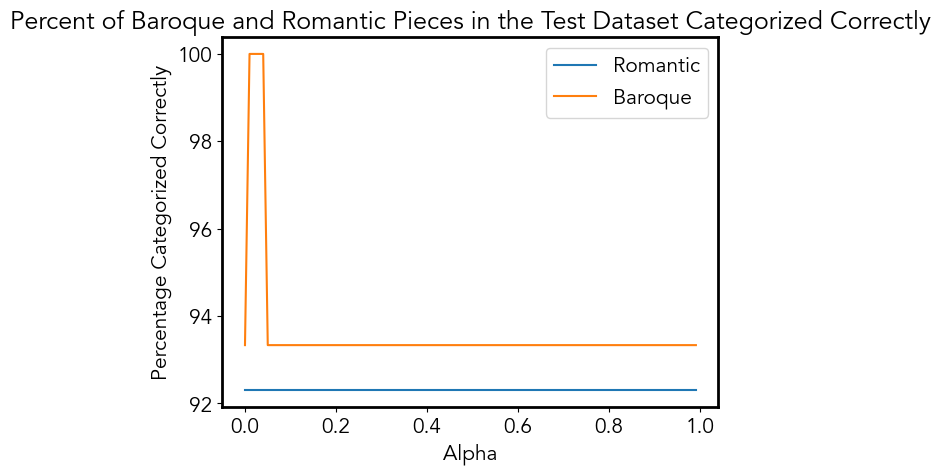

In [384]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0.001,1,0.01), r_correct, label = 'Romantic')
plt.plot(np.arange(0.001,1,0.01), b_correct, label = 'Baroque')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Percentage Categorized Correctly')
plt.title('Percent of Baroque and Romantic Pieces in the Test Dataset Categorized Correctly')

In [385]:
idx = np.where(np.array([int(b) for b in b_correct]) == 100)


In [386]:
np.arange(0.001,1,0.01)[idx]

array([0.011, 0.021, 0.031, 0.041])

In [387]:
b_correct = []
for alpha in np.arange(1,100,1):
    correct = 0
    for b_file in b_test:
        with HiddenPrints():
            test = get_gram_counts(b_file, 2)
            result = calculate_smoothed_likelihood(alpha,test, train_list_b[0], train_list_r[0])
            if result == 'B':
                correct += 1
    b_correct.append(correct/len(b_test)*100)
#     print(f'{correct/len(b_test)*100:.2f}% were predicted correctly')
#     print(correct, len(b_test))

In [388]:
r_correct = []
for alpha in np.arange(1,100,1):
    correct = 0        
    for r_file in r_test:
        with HiddenPrints():
            test = get_gram_counts(r_file, 2)
            result = calculate_smoothed_likelihood(alpha,test, train_list_b[0], train_list_r[0])
            if result == 'R':
                correct += 1
    r_correct.append(correct/len(r_test)*100)
#     print(f'{correct/len(r_test)*100:.2f}% were predicted correctly')


Text(0.5, 1.0, 'Percent of Baroque and Romantic Pieces in the Test Dataset Categorized Correctly')

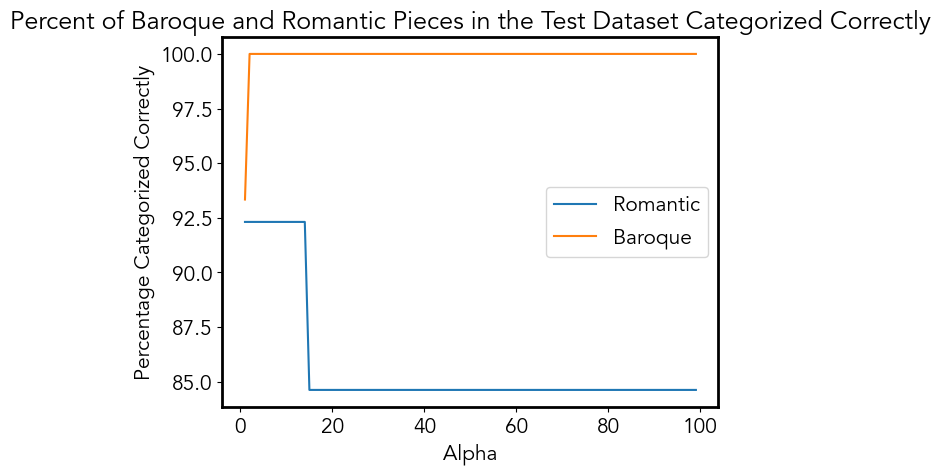

In [389]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1,100,1), r_correct, label = 'Romantic')
plt.plot(np.arange(1,100,1), b_correct, label = 'Baroque')
plt.legend()
plt.xlabel('Alpha')
plt.ylabel('Percentage Categorized Correctly')
plt.title('Percent of Baroque and Romantic Pieces in the Test Dataset Categorized Correctly')

In [390]:
idx = np.where(np.array([int(b) for b in b_correct]) == 100)
np.arange(1,100,1)[idx]

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [391]:
idx = np.where(np.array([int(r) for r in r_correct]) < 90)
np.arange(1,100,1)[idx]

array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
       66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
       83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [392]:
b_test

['MIDI PERIOD CLASSIFICATION/Baroque/bwv1002e_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Baroque/bwv1002b_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Baroque/bwv1001d_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Baroque/bwv1044_1_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Baroque/bwv1041_1_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Baroque/v_concerto_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Baroque/bwv1044_2_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Baroque/bwv1041_2_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Baroque/bwv1002g_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Baroque/HWV322c_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Baroque/HWV322b_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Baroque/bwv1002f_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Baroque/bwv1003_4_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Baroque/bwv1001a_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Baroque/bwv1002h_solo.mid']

In [393]:
r_test

['MIDI PERIOD CLASSIFICATION/Romantic/mazurka33-3_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/mazurka68-2_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/paganini_18_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/Capriccio7_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/Capriccio5_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/mazurka56-2_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/mazurka07-2_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/waltz69-2_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/trio2_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/mazurka07-5_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/paganini_11_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/trio1_solo.mid',
 'MIDI PERIOD CLASSIFICATION/Romantic/mazurka67-4_solo.mid']

# Vary Train-test Sets

In [394]:
import os
from os import listdir
from os.path import isfile, join

mypath_b = 'MIDI PERIOD CLASSIFICATION/Baroque/'
b_files = [mypath_b+f for f in listdir(mypath_b) if (isfile(join(mypath_b, f))) and (f != '.DS_Store') and ('split' not in f)]

mypath_r = 'MIDI PERIOD CLASSIFICATION/Romantic/'
r_files = [mypath_r+f for f in listdir(mypath_r) if (isfile(join(mypath_r, f))) and (f != '.DS_Store') and ('split' not in f)]

b_files.sort()
r_files.sort()

In [395]:
# rs is random state

romantic_accuracy = []
baroque_accuracy = []
overall_accuracy = []


for rs in np.arange(100,120):
    print(rs)
    with HiddenPrints():
        b_train, b_test = train_test_split(b_files, test_size=0.4, shuffle = True, random_state = rs)

        r_train, r_test = train_test_split(r_files, test_size=0.4, shuffle = True, random_state = rs)

        # train Baroque

        train_list_b = []

        for b_file in b_train:
            train_list_b.append(get_gram_counts(b_file,2))

        for train_piece in train_list_b[1:]:
            for key, value in train_piece.items():
                for subkey, subvalue in value.items():
                    train_list_b[0][key][subkey] = subvalue + train_list_b[0][key][subkey]

        # train Romantic

        train_list_r = []

        for r_file in r_train:
            train_list_r.append(get_gram_counts(r_file,2))

        for train_piece in train_list_r[1:]:
            for key, value in train_piece.items():
                for subkey, subvalue in value.items():
                    train_list_r[0][key][subkey] = subvalue + train_list_r[0][key][subkey]


        # Predict Baroque
        correct1 = 0
        for b_file in b_test:
            test = get_gram_counts(b_file, 2)
            result = calculate_smoothed_likelihood(1,test, train_list_b[0], train_list_r[0])
            if result == 'B':
                correct1 += 1

        baroque_accuracy.append(correct1/len(b_test)*100)

        # Predict Romantic
        correct2 = 0
        for r_file in r_test:
            test = get_gram_counts(r_file, 2)
            result = calculate_smoothed_likelihood(1,test, train_list_b[0], train_list_r[0])
            if result == 'R':
                correct2 += 1

        romantic_accuracy.append(correct2/len(r_test)*100)

        overall_accuracy.append((correct1+correct2)/(28)*100)

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


In [396]:
romantic_accuracy

[69.23076923076923,
 76.92307692307693,
 76.92307692307693,
 92.3076923076923,
 100.0,
 92.3076923076923,
 76.92307692307693,
 92.3076923076923,
 76.92307692307693,
 84.61538461538461,
 92.3076923076923,
 84.61538461538461,
 69.23076923076923,
 84.61538461538461,
 92.3076923076923,
 46.15384615384615,
 92.3076923076923,
 84.61538461538461,
 84.61538461538461,
 84.61538461538461]

In [397]:
baroque_accuracy

[100.0,
 100.0,
 80.0,
 93.33333333333333,
 100.0,
 86.66666666666667,
 100.0,
 93.33333333333333,
 73.33333333333333,
 100.0,
 93.33333333333333,
 93.33333333333333,
 100.0,
 93.33333333333333,
 93.33333333333333,
 100.0,
 100.0,
 100.0,
 80.0,
 100.0]

In [398]:
import pandas as pd
df = pd.DataFrame({'Random State':np.arange(100,120), 'Overall Accuracy': overall_accuracy,
                   'Baroque Accuracy':baroque_accuracy, 'Romantic Accuracy':romantic_accuracy})



Text(0, 0.5, 'Test Accuracy Score')

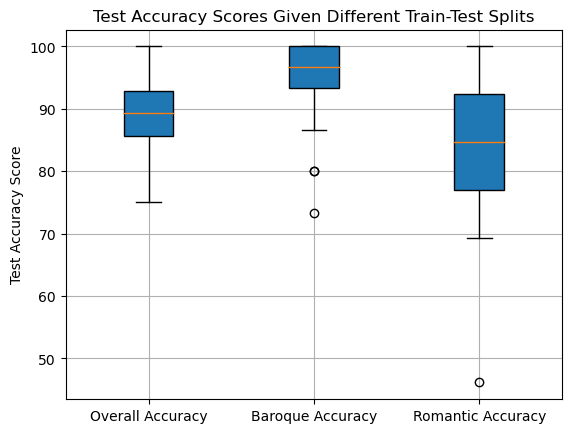

In [399]:
import matplotlib
matplotlib.rc_file_defaults()

plt.boxplot([overall_accuracy, baroque_accuracy, romantic_accuracy], labels = ['Overall Accuracy', 'Baroque Accuracy', 'Romantic Accuracy'], patch_artist=True);
matplotlib.pyplot.grid(axis='both')
plt.title('Test Accuracy Scores Given Different Train-Test Splits')
plt.ylabel('Test Accuracy Score')

**means and standard deviations:**

In [400]:
np.mean(baroque_accuracy)

94.0

In [401]:
np.std(baroque_accuracy)

7.859884081701065

In [402]:
np.mean(romantic_accuracy)

82.69230769230768

In [403]:
np.std(romantic_accuracy)

11.634218047887826

In [404]:
np.mean(overall_accuracy)

88.75

In [405]:
np.std(overall_accuracy)

6.514798695340966